# <center>Test Pixelwise Stats
# <center>Prepared by Denver Lloyd
# <center>3/03/2022

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fivecentplots as fcp
from characterization_ams.stats_engine import pixelwise_stats as ps
from characterization_ams.stats_engine import stats
from characterization_ams.standard_tests import ptc
from characterization_ams.utilities import image
from characterization_ams.utilities import image_generator
import pdb
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Image Generator

### Generate Images

- Here the images generated are done in such a way as to simulate what actual dark current would look like as a function of T [C] (exponential).

In [6]:

tint = np.linspace(0, 1, 10)
rows=100
cols=100
pedestal=168
n_images=100
images = []
temp = pd.DataFrame()
raw = pd.DataFrame()
t_c = {40:224, 50: 232, 60:260, 70:410}
idx_ = 0
for tt in t_c.keys():
    ped_start = 220
    peds = np.linspace(ped_start, t_c[tt], 10)
    for (idx, pp) in enumerate(peds):
        n_images=100
        rfpn=0.1
        cfpn=0.1
        ctn = 0.1
        rtn = 0.1
        ptn = 0.1 + np.sqrt(pp)
        #pfpn= 1 + 0.08 * (pp - ped_start)
        pfpn = 0
        tot_t = np.sqrt(ctn**2 + rtn**2 + ptn**2)
        tot_f = np.sqrt(rfpn**2 + pfpn**2 + cfpn**2)

        # fpn
        imgs = image_generator.gen_images(cfpn=cfpn,
                                          rfpn=rfpn,
                                          pfpn=pfpn,
                                          rtn=rtn,
                                          ptn=ptn,
                                          ctn=ctn,
                                          rows=rows,
                                          cols=cols,
                                          pedestal=pp,
                                          n_images=n_images)

        images.append(imgs)
        
        temp['Power'] = pd.Series(tint[idx])
        temp['imageid'] = idx_
        temp['stack size'] = n_images
        temp['rows'] = rows
        temp['cols'] = cols
        temp['Tint'] = tint[idx]
        temp['T [C]'] = tt
        idx_ += 1
        raw = pd.concat([raw, temp]).reset_index(drop=True)
    
stat_vals = ptc.get_stats(images, raw)
# create average image list for calcs    
avg_ims = []
mean = pd.DataFrame()
for ii in images:
    avg_ims.append(stats.avg_img(ii))

### Dataset Generated

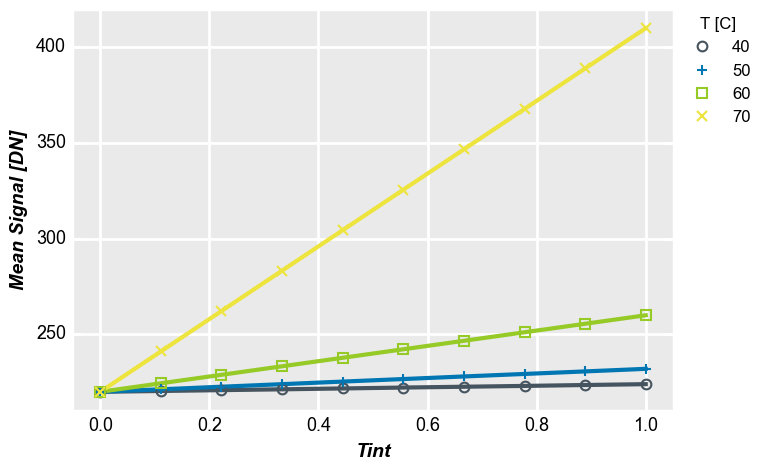

In [4]:
fcp.plot(df=stat_vals, x='Tint', y='Mean Signal [DN]', ax_size=[600,400], legend='T [C]', line_width=3)

## Pixelwise Stats Functions

### Dark Current

- Here a loop and groupby operation is used to get all the images required for the activation energy calculation. If there is only a single dark current operating point the functionc call `ps.dark_current(ims=ims, tint=tint)` is adequate for a single operating point.

~~~ python
    def dark_current(ims, tint):
        """
        Calculate per pixel dark current. This function is
        is lightning fast and uses numpy C implementation via
        np.polyfit()

        Each image should be an average image, if you have stacks
        of images for each operating (tint) point, computer the 
        average using stats.stats.avg_img_stack() prior to passing
        to this function

        Keyword Arguments:
            ims (np.array): 3D array of average images where dim = (tint, rows, cols)
            tint (np.array): 1D array where each element is tint
                            Note: ims[0].shape[0] must equal tint.shape[0]
        Returns:
            dark_im (np.array): 2D array where each element corresponds to
                                dark current for that element in the original
                                image stack
        """
 ~~~

In [5]:
# define data structures
dc_data = []
nq = pd.DataFrame()
temp = pd.DataFrame()
temp_ = list((t_c.keys()))

# groupby T [C] to calculate dark current for each operating point
groups = stat_vals.groupby(['T [C]'])

# iterate over groups
for idx, (nn, gg) in enumerate(groups):
    
    # get index range associated with unique operating point
    idx_start = gg['imageid'].min()
    idx_end = gg['imageid'].max() + 1
    
    # get sub array
    ims = np.array(avg_ims[idx_start:idx_end])
    
    
    ## function call for per pixel dark current ##
    dc = ps.dark_current(ims=ims, tint=tint)
    
    # calculate normal quantiles to demonstrate result
    temp = image.stats(dc)
    temp['T [C]'] = nn
    nq = pd.concat([nq, temp]).reset_index(drop=True)
    
    # add dark current images to data structure for use in activation energy function
    dc_data.append(dc)

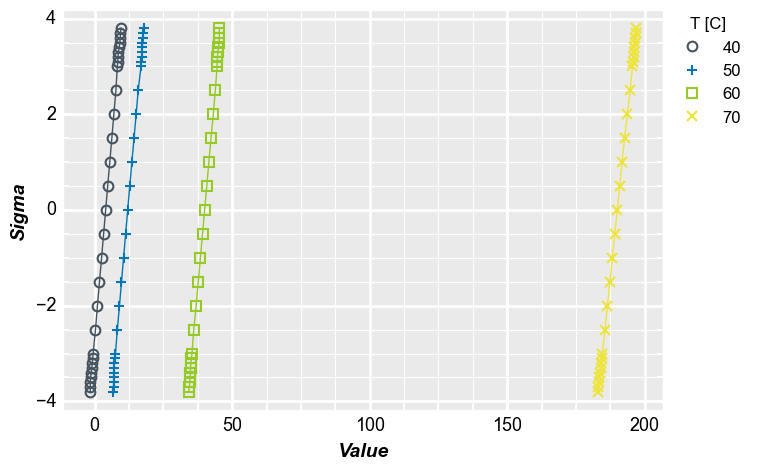

In [6]:
fcp.plot(df=nq, x='Value', y='Sigma', ax_size=[600,400], grid_minor=True, legend='T [C]')

### Activation Energy

~~~ python
    def activation_energy(ims, temp, upper_bound=250):
        """
        Calculate per pixel activation energy [eV]. This function is
        is lightning fast and uses numpy C implementation via
        np.polyfit() each image in the stack should be dark current
        where the first dim (temp, rows, cols) corresponds to the only
        dim of the temp array

        Keyword Arguments:
            ims (np.array): 3D array where dim=(temp, rows, cols)
            temp (np.array): 1D array where each element is temp
                            Note: ims[0].shape[0] must equal temp.shape[0]
            upper_bound (float): upper bound for data in [eV]. Any values above
                                 this will be converted to np.nan, this is primarly
                                 for extreme outliers
        Returns:
            dark_im (np.array): 2D array where each element corresponds to
                                activation energy [eV] for that element in the original
                                image stack
        """
 ~~~

In [7]:
ae = ps.activation_energy(dc_data, temp_)
aenq = image.stats(ae)

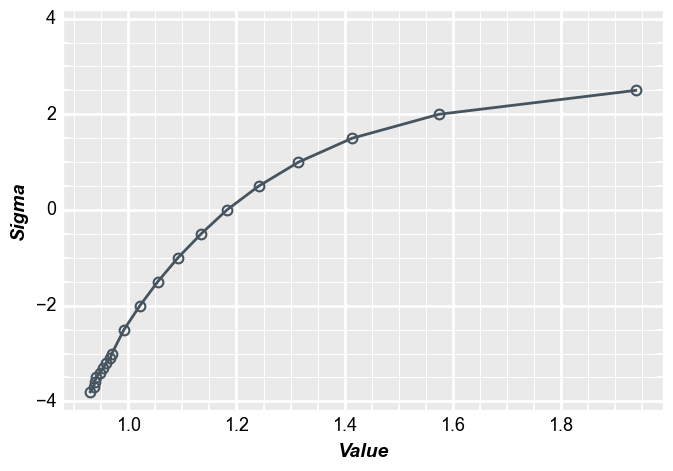

In [8]:
fcp.plot(df=aenq, x='Value', y='Sigma', ax_size=[600,400], grid_minor=True, line_width=2)

### Calc Pixelwise (Generic)

- This is a generic function for calculating anything on a per pixel basis. This means a user defined function. A demonstration is shown below.

~~~ python
    def calc_pixelwise(func, arr3d, **kwargs):
        """
        generic wrapper to calculate pixelwise stats using
        np.apply_along_axis().
        Note: this is very slow and should only be used if there is
              no other way.

        The function is always applied along axis 2

        Keyword Args:
            func (function): function to be applied to each pixel
            arr3d (np.array): 3D numpy array
            kwargs (): Any arguments required by func
        Retuns:
            arr2d (np.array): 2D array where each pixel value is the result
                              of the per pixel calculation
        """
~~~

In [9]:
def example_pixelwise(vals, constant1, constant2):
    """
    For this example function will take constant1 + constant2 at every pixel location
    just to demonstrate the functionality. Obviously in practice we would want to utilize
    the imgs variable :)
    
    Here 'vals' is the pixel array at a given (x, y) location.
    """
    
    return constant1 + constant2

In [10]:
def example_pixelwise2(yvals, xvals, constant1):
    """
    A more realistic example, let's make a 5th order polynomial fit and return the coefficients of the fit at
    each pixel
    """
    
    coef = np.polyfit(xvals, yvals, deg=5)
    
    return coef * constant1

- `func` keyword points to our user defined function to be applied at each pixel
- `arr3d` keyword is always our stack of images, `func` will be applied along axis 0
- All other arguments are whatever is required for the user defined function `func` to be ran

#### Example #1

In [11]:
cp = ps.calc_pixelwise(func=example_pixelwise, arr3d=dc_data, constant1=5, constant2=5)

In [12]:
cp

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]])

#### Example #2

In [13]:
cp = ps.calc_pixelwise(func=example_pixelwise2, arr3d=dc_data, xvals=temp_, constant1=5)

- Array returned is original shape, but has 6 elements in each pixel location because we returned the coefficients of a 5th order polynomial fit in `example_pixelwise2`.

In [14]:
cp.shape

(6, 100, 100)